# Try: padding audio directly by adding silence

In [109]:
import torch
import torchaudio
import random
from ssd_paths import *
import os
import matplotlib.pyplot as plt
from misc_tools import *
import torch.nn as nn

In [110]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:,:max_len]

    elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
        
    return (sig, sr)

In [115]:
class Padder(nn.Module): 
    def __init__(self, sample_rate=16000, pad_len_ms=250, noise_level=0.001): 
        super().__init__()
        self.sample_rate = sample_rate
        self.pad_len_frame = sample_rate // 1000 * pad_len_ms
        self.noise_level = noise_level
    
    def forward(self, sig): 
        num_rows, sig_len = sig.shape
        if (sig_len > self.pad_len_frame):
            # Truncate the signal to the given length
            sig = sig[:,:self.pad_len_frame]

        elif (sig_len < self.pad_len_frame):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, self.pad_len_frame - sig_len)
            pad_end_len = self.pad_len_frame - sig_len - pad_begin_len

            # Pad with 0s
            # pad_begin = torch.zeros((num_rows, pad_begin_len))
            # pad_end = torch.zeros((num_rows, pad_end_len))
            pad_begin = torch.randn((num_rows, pad_begin_len)) * self.noise_level
            pad_end = torch.randn((num_rows, pad_end_len)) * self.noise_level

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        return sig

In [122]:
padder = Padder(noise_level=0.0001)

In [123]:
sig, sr = torchaudio.load(os.path.join(strain_cut_audio_, "19/198/0001/", "19-198-0001-0010.flac"))
# padsig, sr = pad_trunc((sig, sr), 250)
padsig = padder(sig)

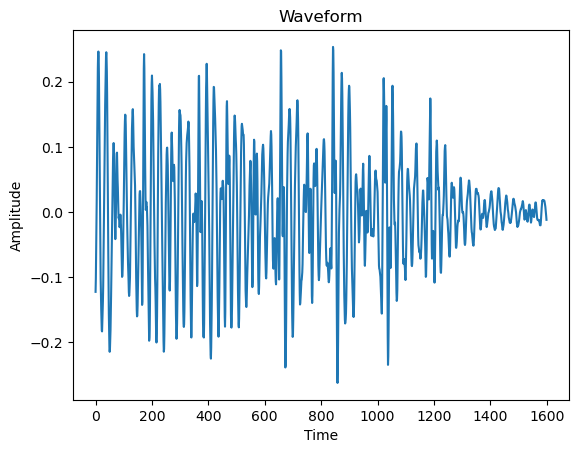

In [124]:
plt.plot(sig[0].numpy())
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

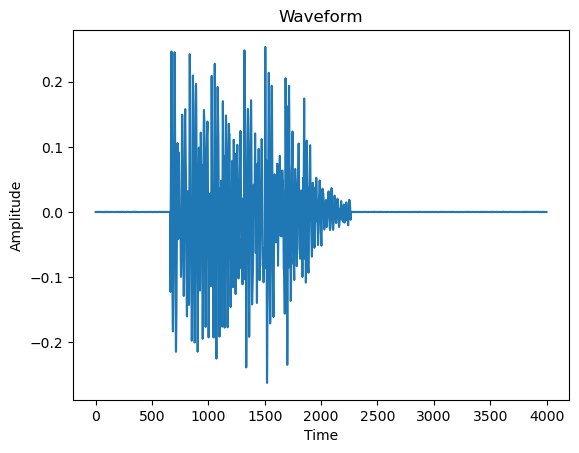

In [125]:
plt.plot(padsig[0].numpy())
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

In [126]:
MyAudio.play_audio_torch(sig, sr)

In [127]:
MyAudio.play_audio_torch(padsig, sr)

## Plot Mel

In [40]:
class MelSpecTransform(nn.Module): 
    def __init__(self, sample_rate, n_fft=400, n_mels=64, filter=None, norm=None, resample=None): 
        super().__init__()
        self.sample_rate = sample_rate
        n_stft = int((n_fft//2) + 1)
        self.filter = filter
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels, n_fft=n_fft, power=2)
        self.amp_to_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)
        self.inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_mels=n_mels, n_stft=n_stft)
        self.grifflim = torchaudio.transforms.GriffinLim(n_fft=n_fft)
        self.norm = norm
        self.resample = resample
    
    def forward(self, waveform):
        # transform to mel_spectrogram
        if self.filter: 
            waveform = self.filter(waveform, self.sample_rate)

        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        mel_spec = mel_spec.squeeze()
        mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)

        # mel_spec = torch.log(mel_spec + 1e-9)   # 20231121 newly added log
        mel_spec = self.amp_to_db(mel_spec)
        if self.norm: 
            mel_spec = self.norm(mel_spec)
        
        if self.resample: 
            mel_spec = self.resample(mel_spec)

        return mel_spec
    
class Normalizer: 
    @staticmethod
    def norm_strip_mvn(mel_spec):
        eps = 1e-9
        mean = mel_spec.mean(1, keepdim=True)
        std = mel_spec.std(1, keepdim=True, unbiased=False)
        norm_spec = (mel_spec - mean) / (std + eps)
        return norm_spec

    @staticmethod
    def norm_mvn(mel_spec):
        eps = 1e-9
        mean = mel_spec.mean()
        std = mel_spec.std(unbiased=False)
        norm_spec = (mel_spec - mean) / (std + eps)
        return norm_spec
    
    @staticmethod
    def norm_time_mvn(mel_spec):
        eps = 1e-9
        mean = mel_spec.mean(0, keepdim=True)
        std = mel_spec.std(0, keepdim=True, unbiased=False)
        norm_spec = (mel_spec - mean) / (std + eps)
        return norm_spec

    @staticmethod
    def norm_minmax(mel_spec):
        min_val = mel_spec.min()
        max_val = mel_spec.max()
        norm_spec = (mel_spec - min_val) / (max_val - min_val)
        return norm_spec
    
    @staticmethod
    def norm_strip_minmax(mel_spec):
        min_val = mel_spec.min(1, keepdim=True)[0]
        max_val = mel_spec.max(1, keepdim=True)[0]
        norm_spec = (mel_spec - min_val) / (max_val - min_val)
        return norm_spec
    
    @staticmethod
    def norm_pcen(mel_spec):
        return mel_spec

In [54]:
mt = MelSpecTransform(sample_rate=16000, n_fft=400, n_mels=64, norm=Normalizer.norm_minmax)

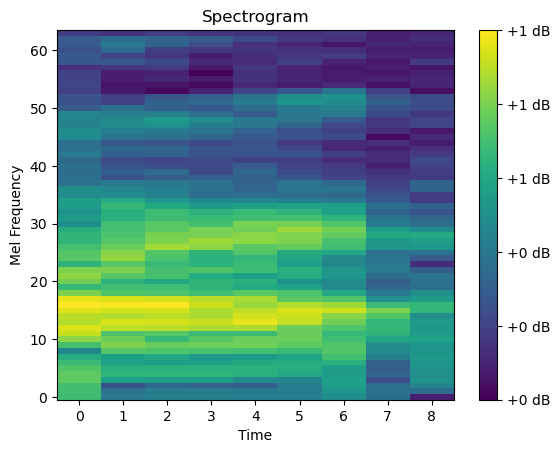

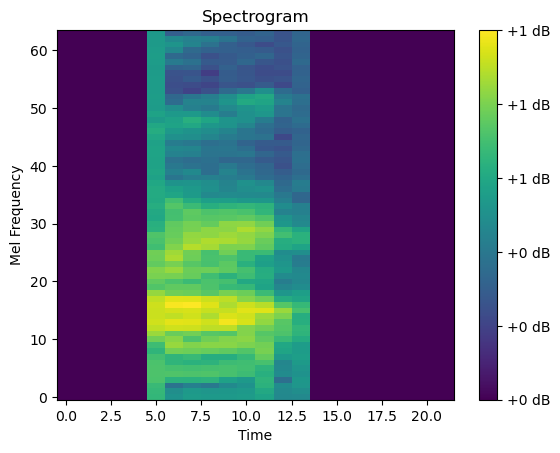

In [102]:
sig, sr = torchaudio.load(os.path.join(strain_cut_audio_, "19/198/0001/", "19-198-0001-0010.flac"))
padsig, sr = pad_trunc((sig, sr), 265)
mel = mt(sig)
padmel = mt(padsig)
plt.imshow(mel[0], aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

plt.imshow(padmel[0], aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [103]:
class MelSpecTransform(nn.Module): 
    def __init__(self, sample_rate, n_fft=400, n_mels=64, filter=None, norm=None, resample=None): 
        super().__init__()
        self.sample_rate = sample_rate
        n_stft = int((n_fft//2) + 1)
        self.filter = filter
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels, n_fft=n_fft, power=2)
        self.amp_to_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)
        # self.inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_mels=n_mels, n_stft=n_stft)
        # self.grifflim = torchaudio.transforms.GriffinLim(n_fft=n_fft)
        self.norm = norm
        self.resample = resample
    
    def forward(self, waveform):
        # transform to mel_spectrogram
        if self.filter: 
            waveform = self.filter(waveform, self.sample_rate)

        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        # mel_spec = mel_spec.squeeze()
        # mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)

        # mel_spec = torch.log(mel_spec + 1e-9)   # 20231121 newly added log
        mel_spec = self.amp_to_db(mel_spec)
        if self.norm: 
            mel_spec = self.norm(mel_spec)
        
        if self.resample: 
            mel_spec = self.resample(mel_spec)

        return mel_spec

In [104]:
mt = MelSpecTransform(sample_rate=16000, n_fft=400, n_mels=64, norm=Normalizer.norm_minmax)

In [107]:
sig, sr = torchaudio.load(os.path.join(strain_cut_audio_, "19/198/0001/", "19-198-0001-0010.flac"))
padsig, sr = pad_trunc((sig, sr), 250)
mel = mt(sig)
padmel = mt(padsig)

In [108]:
mel.shape, padmel.shape

(torch.Size([1, 64, 9]), torch.Size([1, 64, 21]))